In [1]:
from collections.abc import Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from input_data import lb3_time_opticaldensity_ph_glucose_protein_37

In [18]:
_TIMESTAMPS = len(lb3_time_opticaldensity_ph_glucose_protein_37) - 1
_TIME = lb3_time_opticaldensity_ph_glucose_protein_37['Time'].values

In [3]:
def simulate(
    params: np.ndarray,
    input_data: pd.DataFrame,
    timestamps: int,
    temperature: float = 1.0,
    aeration: float = 1.0,
    stirring: float = 1.0,
) -> tuple[np.ndarray, ...]:
    optical_densitys, phs, glucoses, proteins = (
        [input_data["OpticalDensity"].iloc[0]],
        [input_data["pH"].iloc[0]],
        [input_data["Glucose"].iloc[0]],
        [input_data["Protein"].iloc[0]],
    )

    for _ in range(timestamps):
        optical_density, ph, glucose, protein = optical_densitys[-1], phs[-1], glucoses[-1], proteins[-1]
        environmental_effect = temperature * aeration * stirring

        optical_density_base = (
            params[0] * optical_density
            + params[1] * ph
            + params[2] * glucose
            + params[3] * protein
        )
        optical_density_next = optical_density_base * environmental_effect
        ph_next = params[4] + params[5] * ph - params[6] * optical_density_next
        glucose_next = glucose - params[7] * optical_density_next
        protein_next = protein + params[8] * optical_density_next - params[9] * protein

        optical_densitys.append(optical_density_next)
        phs.append(ph_next)
        glucoses.append(glucose_next)
        proteins.append(protein_next)
    
    return np.array(optical_densitys), np.array(phs), np.array(glucoses), np.array(proteins)

In [4]:
params = np.random.rand(14) * 0.01
params

array([0.00910946, 0.00603087, 0.00209055, 0.00036846, 0.00727686,
       0.00804177, 0.00753976, 0.00976851, 0.00993309, 0.00159505,
       0.00473106, 0.00899825, 0.00151064, 0.00504935])

In [5]:
def normalize(
    optical_density: np.ndarray,
    ph: np.ndarray,
    glucose: np.ndarray,
    protein: np.ndarray
) -> tuple[float]:
    _std = lambda x: float(np.std(x)) if float(np.std(x)) > 0 else 1.0
    return map(_std, (optical_density, ph, glucose, protein))


def make_loss(input_data: pd.DataFrame) -> Callable:
    optical_desnity_obs = input_data["OpticalDensity"].values
    ph_obs = input_data["pH"].values
    glucose_obs = input_data["Glucose"].values
    protein_obs = input_data["Protein"].values

    std_optical_density, std_ph, std_glucose, std_protein = normalize(
        optical_desnity_obs, ph_obs, glucose_obs, protein_obs
    )

    def loss(params: np.ndarray) -> float:
        optical_density_pred, ph_pred, glucose_pred, protein_pred = simulate(
            params, input_data, _TIMESTAMPS
        )
        rX  = (optical_density_pred  - optical_desnity_obs) / std_optical_density
        rpH = (ph_pred - ph_obs) / std_ph
        rG  = (glucose_pred  - glucose_obs) / std_glucose
        rB  = (protein_pred  - protein_obs) / std_protein
        error = float(np.sum(rX**2) + np.sum(rpH**2) + np.sum(rG**2) + np.sum(rB**2))
        return error
    return loss

In [6]:
loss_func = make_loss(lb3_time_opticaldensity_ph_glucose_protein_37)
optimal_params = minimize(
    loss_func,
    params,
    method='L-BFGS-B',
    options={'maxiter': 10_000}
)
optimal_params.x

array([-3.15142019e+00, -1.44527067e+00, -6.07172732e-02,  9.75268764e-01,
        6.46422395e+00, -7.54311986e-02,  2.06462434e+00,  3.50815312e+00,
       -1.16605210e+00, -9.29362071e-02,  4.73106341e-03,  8.99824868e-03,
        1.51063997e-03,  5.04935415e-03])

In [7]:
optical_density_model_temp37, ph_temp_37, glucoses_temp_37, proteins_temp_37 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS
)
optical_density_model_temp35, ph_temp_35, glucoses_temp_35, proteins_temp_35 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=0.95
)

In [8]:
def plot_optical_density_multi_temp(
    input_data: pd.DataFrame,
    model_curves: dict[str, np.ndarray],
    title: str = 'DBN model simulation with optimized parameters (with temperature multiplier)'
):
    time = input_data['Time'].values
    plt.figure(figsize=(10, 6))

    for label, y in model_curves.items():
        plt.plot(time, y, label=f'OpticalDensity model ({label})', marker='o')
    
    plt.plot(
        time, input_data['OpticalDensity'].values, 'o--', label='OpticalDensity experimental'
    )
    plt.legend()
    plt.xlabel('Time (hours)')
    plt.ylabel('Optical Density')
    plt.title(title)
    plt.grid()
    plt.show()

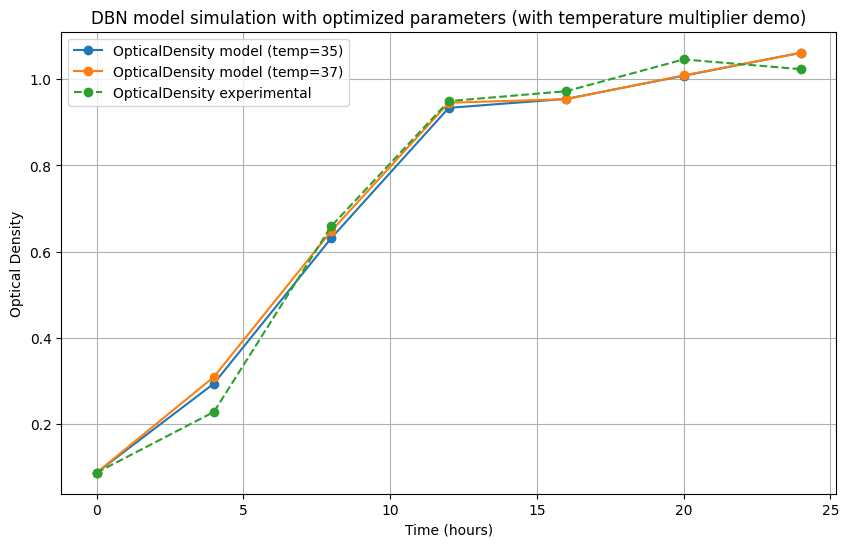

In [9]:
plot_optical_density_multi_temp(
    lb3_time_opticaldensity_ph_glucose_protein_37,
    {
        'temp=35': optical_density_model_temp35,
        'temp=37': optical_density_model_temp37,
    },
    title='DBN model simulation with optimized parameters (with temperature multiplier demo)'
)

In [10]:
def apply_environmental_reduction_postprocess(
    optical_density_optimal: np.ndarray,
    temperature_reduction: float = 1.0,
    aeration_reduction: float = 1.0,
    stirring_reduction: float = 1.0,
) -> np.ndarray:
    """
    Apply environmental effects as post-processing to maintain consistent percentage reduction.
    This approach multiplies the optimal trajectory by environmental multipliers,
    ensuring that the reduction is maintained throughout the entire trajectory,
    unlike the feedback-based approach which causes convergence.
    """
    total_multiplier = temperature_reduction * aeration_reduction * stirring_reduction
    return optical_density_optimal * total_multiplier

In [19]:
optical_density_model_temp35 = apply_environmental_reduction_postprocess(
    optical_density_model_temp37,
    temperature_reduction=0.976458
)

optical_density_model_temp40 = apply_environmental_reduction_postprocess(
    optical_density_model_temp37,
    temperature_reduction=0.950491,
)

optical_density_model_temp45 = apply_environmental_reduction_postprocess(
    optical_density_model_temp37,
    temperature_reduction=0.814320
)

# Verify the reduction is maintained
print("Improved Method - Percentage Difference from Optimal at Each Timestamp:")
for i, time in enumerate(lb3_time_opticaldensity_ph_glucose_protein_37['Time'].values):
    temp_35 = ((optical_density_model_temp35[i] - optical_density_model_temp37[i]) 
                 / optical_density_model_temp37[i] * 100)
    temp_40 = ((optical_density_model_temp40[i] - optical_density_model_temp37[i]) 
                 / optical_density_model_temp37[i] * 100)
    temp_45 = ((optical_density_model_temp45[i] - optical_density_model_temp37[i]) 
                 / optical_density_model_temp37[i] * 100)
    print(
        f"t={time:4.1f}h: 35C reduction = {temp_35:6.2f}, 40C reduction = {temp_40:6.2f}, 45C reduction = {temp_45:6.2f}"
    )

Improved Method - Percentage Difference from Optimal at Each Timestamp:
t= 0.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57
t= 4.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57
t= 8.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57
t=12.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57
t=16.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57
t=20.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57
t=24.0h: 35C reduction =  -2.35, 40C reduction =  -4.95, 45C reduction = -18.57


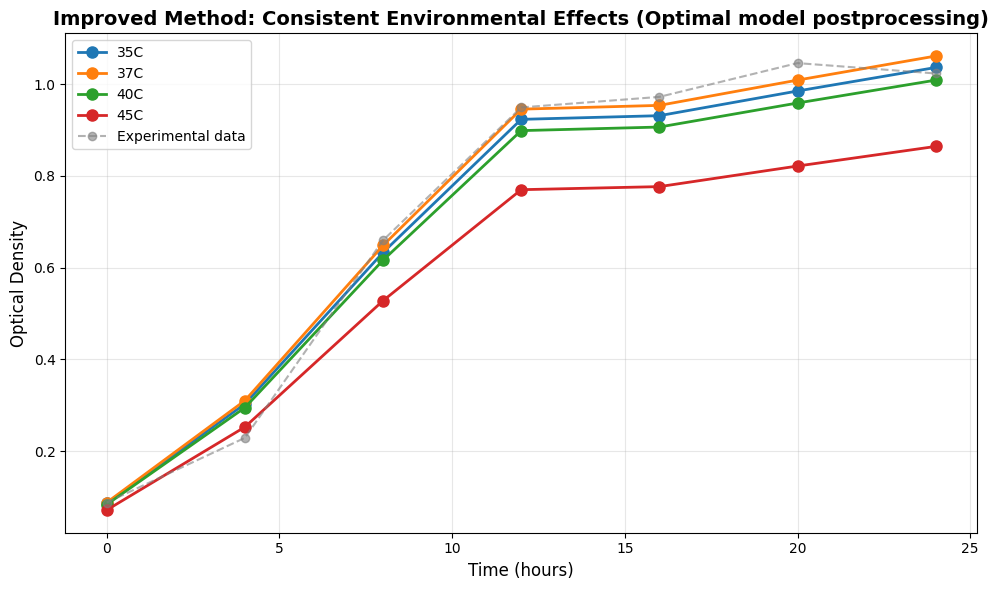

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(_TIME, optical_density_model_temp35, 'o-', label='35C', linewidth=2, markersize=8)
plt.plot(_TIME, optical_density_model_temp37, 'o-', label='37C', linewidth=2, markersize=8)
plt.plot(_TIME, optical_density_model_temp40, 'o-', label='40C', linewidth=2, markersize=8)
plt.plot(_TIME, optical_density_model_temp45, 'o-', label='45C', linewidth=2, markersize=8)
plt.plot(_TIME, lb3_time_opticaldensity_ph_glucose_protein_37['OpticalDensity'].values, 
         'o--', label='Experimental data', color='gray', alpha=0.6)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Optical Density', fontsize=12)
plt.title('Improved Method: Consistent Environmental Effects (Optimal model postprocessing)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
